In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 111.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.6 MB/s eta 0

In [3]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [4]:
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

\

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



-

hub://activeloop/nih-chest-xray-test loaded successfully.



In [5]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [6]:
class SubNet(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, pool_kernel, pool_stride, dropout_rate):
    super(SubNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.LeakyReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.LeakyReLU(inplace=True)
    self.max_pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
    self.drop = nn.Dropout(dropout_rate)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu2(out)
    out = self.max_pool(out)
    out = self.drop(out)
    return out


class CustomNet(nn.Module):
  def __init__(self):
    super(CustomNet, self).__init__()
    self.block0 = SubNet(1, 32, 5, 1, 1, 2, 2, 0.1)
    self.block1 = SubNet(32, 64, 5, 1, 1, 2, 2, 0.1)
    self.block2 = SubNet(64, 128, 3, 1, 1, 2, 2, 0.1)
    self.block3 = SubNet(128, 256, 3, 1, 1, 2, 2, 0.1)
    self.block4 = SubNet(256, 512, 3, 1, 1, 2, 2, 0.1)
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(512, 256)
    self.fc2 = nn.Linear(256, 15)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.block0(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.avg_pool(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

model = CustomNet()

In [7]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [8]:
def load_model(result_file_model, model_to_load, model, epoch, device):
    model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f'Model loaded from {model_save_path}')
    return model

In [9]:
label_names = test_ds.findings.info.class_names
print(label_names)

['No Finding', 'Hernia', 'Emphysema', 'Nodule', 'Pneumonia', 'Consolidation', 'Cardiomegaly', 'Effusion', 'Mass', 'Pleural_Thickening', 'Atelectasis', 'Pneumothorax', 'Fibrosis', 'Infiltration', 'Edema']


In [10]:
model_name = "SSN_CustomNet"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
epoch = 7

criterion = class_averaged_binary_cross_entropy

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

loaded_model = load_model(result_file_model, model_name, model, epoch, device)
loaded_model.to(device)
loaded_model.eval()

Running on cuda
Model loaded from /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_7.pt


CustomNet(
  (block0): SubNet(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (block1): SubNet(
    (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [11]:
# Containers to store predictions and true labels
all_preds = torch.tensor([]).to(device)
all_labels = torch.tensor([]).to(device)

# Go through the train_loader
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        output = model(data)
        all_preds = torch.cat((all_preds, output), dim=0)
        all_labels = torch.cat((all_labels, label), dim=0)

In [12]:
all_preds = all_preds.cpu()
print(all_preds)

tensor([[6.1862e-01, 5.2075e-03, 1.1344e-02,  ..., 2.1951e-02, 1.2893e-01,
         2.2146e-03],
        [7.3325e-01, 6.6441e-03, 2.8663e-02,  ..., 4.6243e-02, 6.1160e-02,
         1.8052e-03],
        [5.2089e-01, 8.1523e-03, 2.6310e-02,  ..., 3.4127e-02, 1.2124e-01,
         4.9627e-03],
        ...,
        [9.0869e-01, 1.7851e-04, 1.8212e-03,  ..., 4.0731e-03, 2.6852e-02,
         3.8283e-04],
        [8.5700e-01, 5.5613e-04, 1.5316e-03,  ..., 6.2258e-03, 4.5683e-02,
         1.2030e-03],
        [8.7763e-01, 1.3478e-04, 5.4847e-04,  ..., 2.7912e-03, 3.7098e-02,
         1.2155e-03]])


In [13]:
all_labels = all_labels.cpu()
print(all_labels)

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [14]:
def accuracy_multi(preds, targs, thresh=0.5):
    preds = (preds > thresh).float()
    return (preds == targs).float().mean()

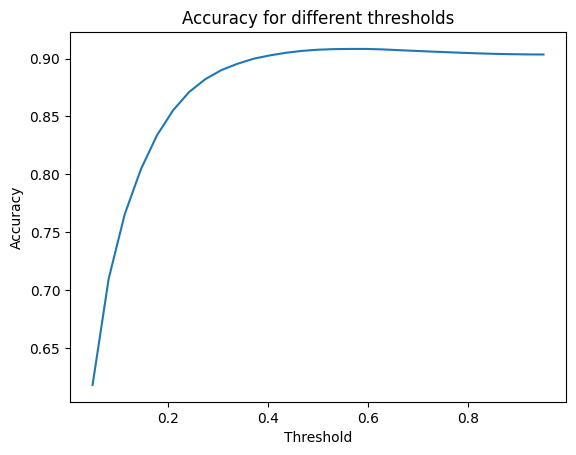

In [15]:
thresholds = torch.linspace(0.05, 0.95, 29).cpu().numpy()
accuracies = [accuracy_multi(all_preds, all_labels, thresh=i).cpu().numpy() for i in thresholds]

plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy for different thresholds")
plt.show()

In [16]:
threshold = 0.55
all_preds_binary = (all_preds > threshold).float().cpu()

In [17]:
all_preds_binary

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

Micro-averaged ROC AUC: 0.8251279760151777
Macro-averaged ROC AUC: 0.724045246179673
ROC AUC for label No Finding: 0.6974337991439767
ROC AUC for label Hernia: 0.8115034687719362
ROC AUC for label Emphysema: 0.7018956993110876
ROC AUC for label Nodule: 0.6324715942115923
ROC AUC for label Pneumonia: 0.6215579782490049
ROC AUC for label Consolidation: 0.704833580712338
ROC AUC for label Cardiomegaly: 0.8329246404651401
ROC AUC for label Effusion: 0.7798697864897985
ROC AUC for label Mass: 0.7118760156813134
ROC AUC for label Pleural_Thickening: 0.7019967492408438
ROC AUC for label Atelectasis: 0.7080662001267249
ROC AUC for label Pneumothorax: 0.7524132230282494
ROC AUC for label Fibrosis: 0.7439035142418458
ROC AUC for label Infiltration: 0.665482563690331
ROC AUC for label Edema: 0.7944498793309138


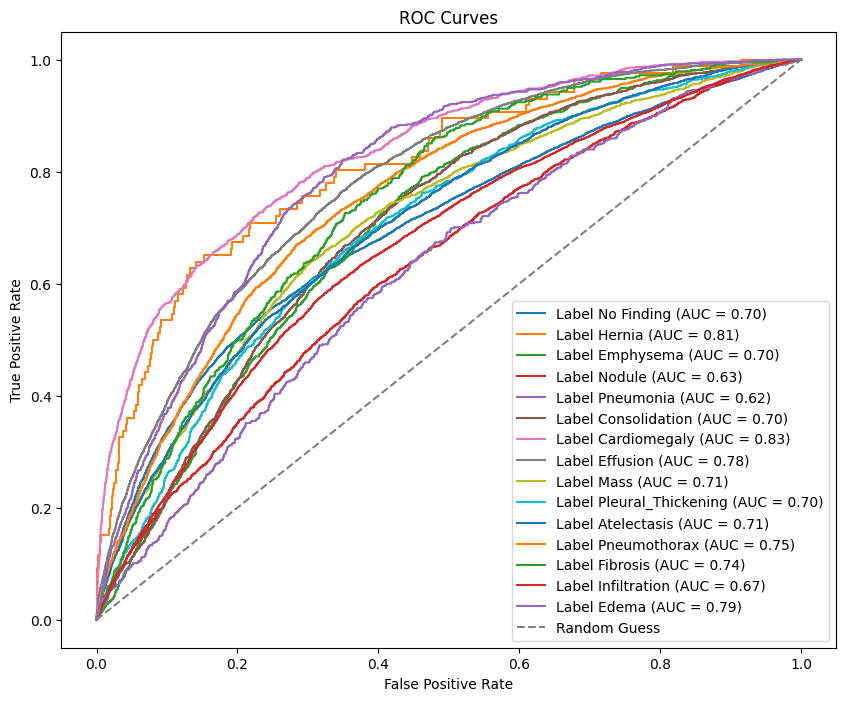

In [18]:
micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
print(f'Micro-averaged ROC AUC: {micro_auc_score}')

macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
print(f'Macro-averaged ROC AUC: {macro_auc_score}')

num_labels = len(label_names)
plt.figure(figsize=(10, 8))

per_class_auc_scores = []

for label_index in range(num_labels):
  try:
    auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
    per_class_auc_scores.append(auc_score)
    print(f'ROC AUC for label {label_names[label_index]}: {auc_score}')

    fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
    plt.plot(fpr, tpr, label=f'Label {label_names[label_index]} (AUC = {auc_score:.2f})')
  except ValueError:
    print(f'ROC AUC for label {label_names[label_index]}: Not Defined (No positive examples in labels)')
    per_class_auc_scores.append(None)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [19]:
mse_loss = nn.MSELoss()
total_loss = 0
total_losses = torch.zeros(all_preds.size(1))
num_samples = 0

loss = mse_loss(all_preds, all_labels)
total_loss += loss.item() * all_preds.size(0)

# loop for each label
for i in range(all_preds.size(1)):
  preds = all_preds[:, i]  # Select predictions for a specific label
  labels = all_labels[:, i]  # Select target labels for the same label

  loss = mse_loss(preds, labels)
  total_losses[i] += torch.sum(loss).item()

num_samples += all_preds.size(0)

average_loss = total_loss / num_samples
average_losses = total_losses / num_samples

In [20]:
mse, mse_per_label = average_loss, average_losses

print(f"Mean Squared Error (MSE): {mse:.4f}")
for label_index, mse in enumerate(mse_per_label):
    print(f"Mean Squared Error (MSE) for Label {label_index}: {mse:.9f}")

Mean Squared Error (MSE): 0.0724
Mean Squared Error (MSE) for Label 0: 0.000008146
Mean Squared Error (MSE) for Label 1: 0.000000130
Mean Squared Error (MSE) for Label 2: 0.000001601
Mean Squared Error (MSE) for Label 3: 0.000002293
Mean Squared Error (MSE) for Label 4: 0.000000827
Mean Squared Error (MSE) for Label 5: 0.000002539
Mean Squared Error (MSE) for Label 6: 0.000001396
Mean Squared Error (MSE) for Label 7: 0.000005161
Mean Squared Error (MSE) for Label 8: 0.000002474
Mean Squared Error (MSE) for Label 9: 0.000001637
Mean Squared Error (MSE) for Label 10: 0.000004073
Mean Squared Error (MSE) for Label 11: 0.000003508
Mean Squared Error (MSE) for Label 12: 0.000000645
Mean Squared Error (MSE) for Label 13: 0.000006682
Mean Squared Error (MSE) for Label 14: 0.000001330


In [21]:
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(all_labels, all_preds_binary)
print(cm)

[[[13780  1955]
  [ 6051  3810]]

 [[25510     0]
  [   86     0]]

 [[24503     0]
  [ 1093     0]]

 [[23973     0]
  [ 1623     0]]

 [[25041     0]
  [  555     0]]

 [[23781     0]
  [ 1815     0]]

 [[24498    29]
  [ 1023    46]]

 [[19602  1336]
  [ 3283  1375]]

 [[23793    55]
  [ 1726    22]]

 [[24453     0]
  [ 1143     0]]

 [[22315     2]
  [ 3278     1]]

 [[22930     1]
  [ 2665     0]]

 [[25161     0]
  [  435     0]]

 [[19326   158]
  [ 5955   157]]

 [[24671     0]
  [  925     0]]]


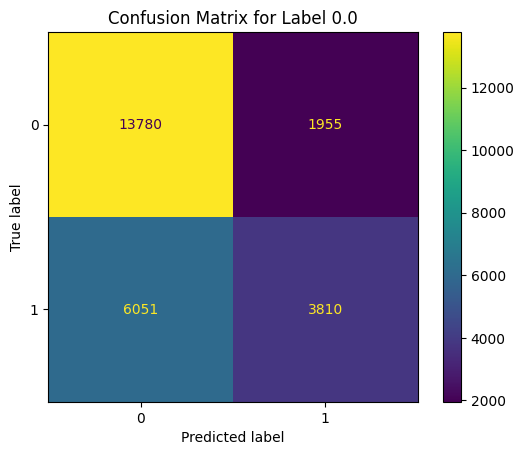

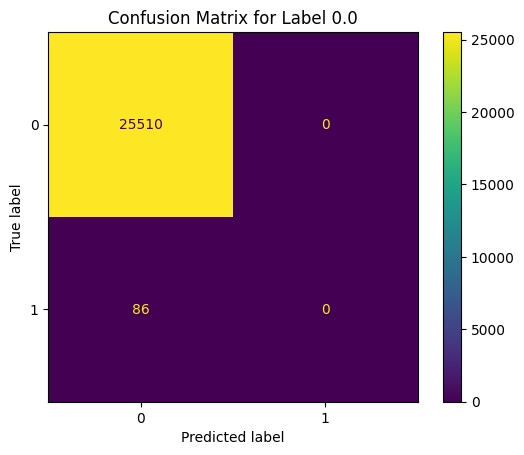

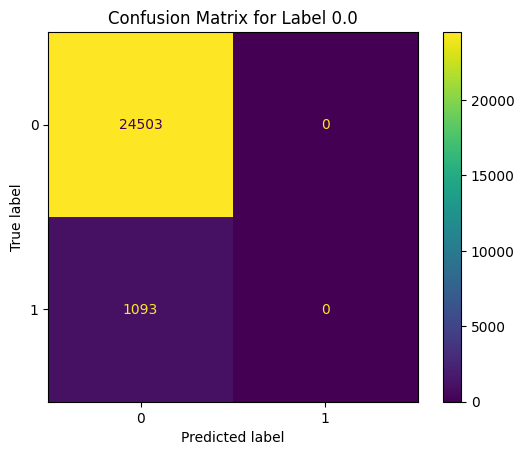

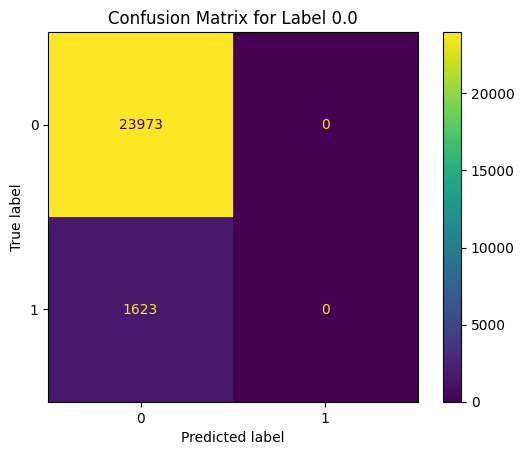

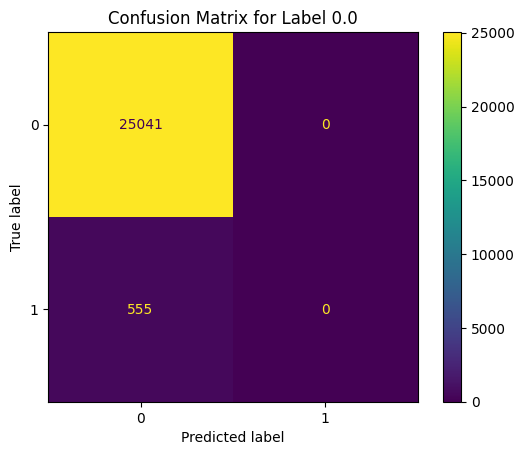

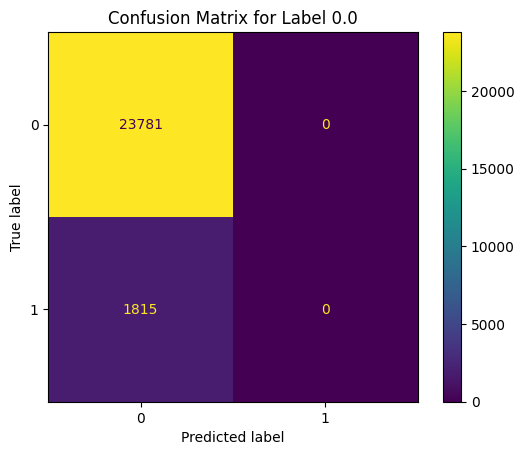

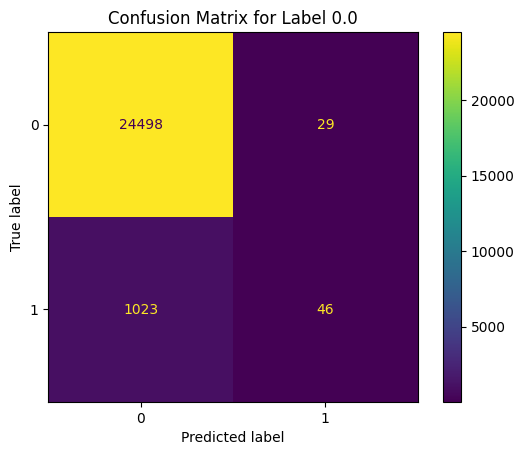

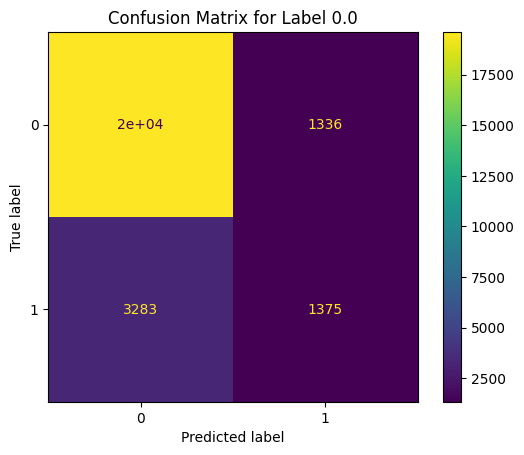

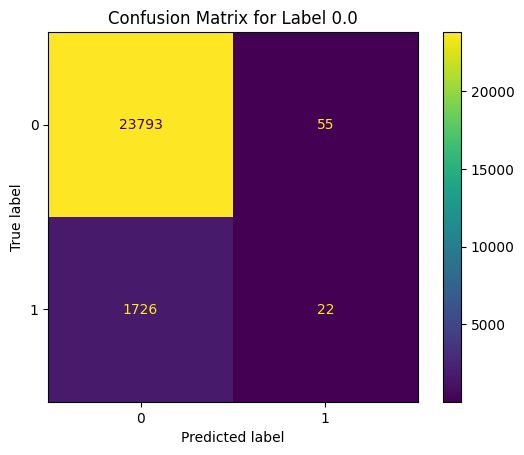

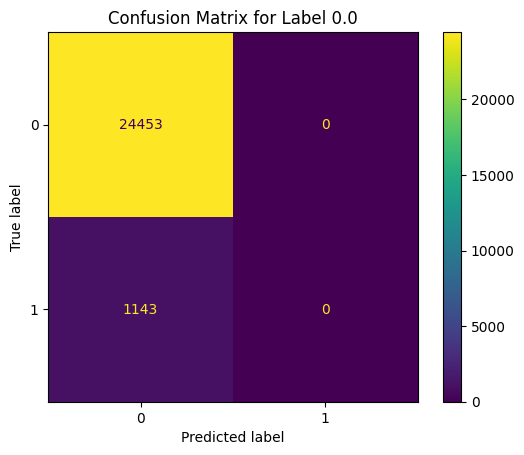

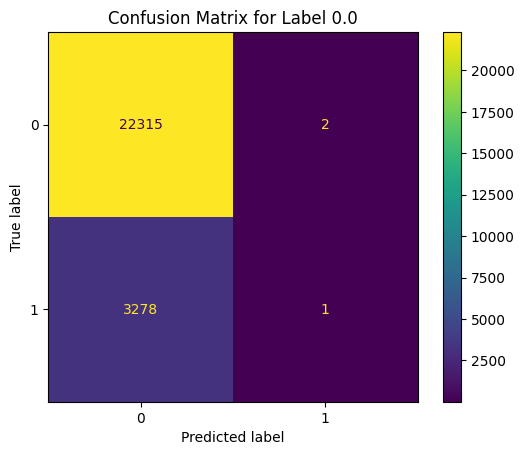

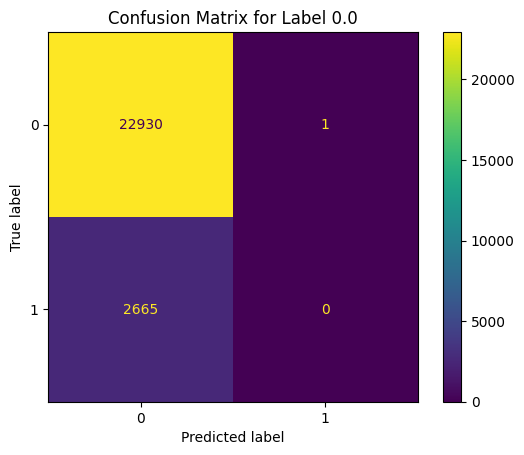

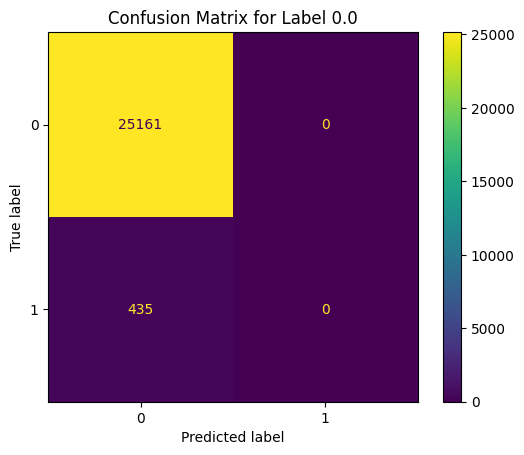

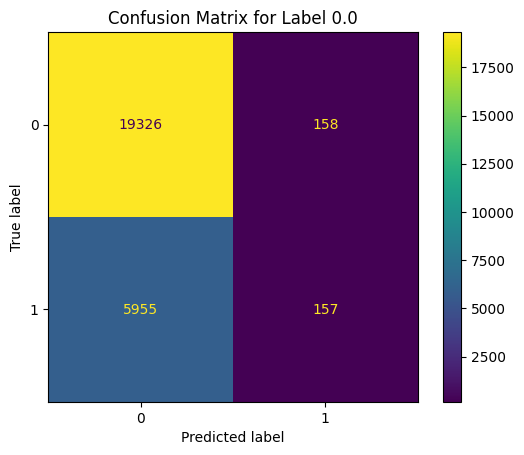

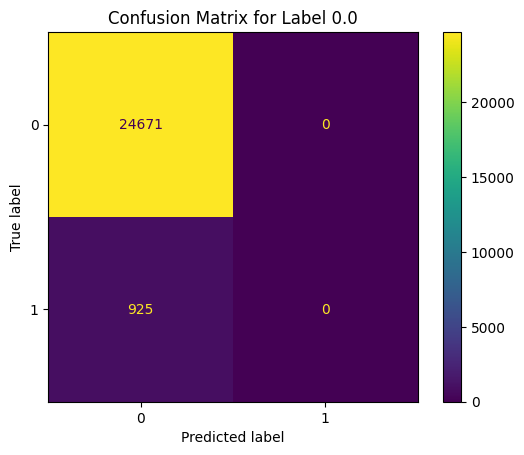

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(cm.shape[0]):
    display = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    fig, ax = plt.subplots()
    display.plot(ax=ax)
    plt.title(f"Confusion Matrix for Label {labels[i]}")
    plt.show()

In [23]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

In [24]:
def calculate_sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_negatives = confusion_matrix[1, 0]
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

In [25]:
for i in range(len(cm)):
    specificities = calculate_specificity(cm[i])
    sensitivities = calculate_sensitivity(cm[i])
    print(f"Label {labels[i]}: Specificity = {specificities:.4f}, Sensitivity = {sensitivities:.4f}")

Label 0.0: Specificity = 0.8758, Sensitivity = 0.3864
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 0.9988, Sensitivity = 0.0430
Label 0.0: Specificity = 0.9362, Sensitivity = 0.2952
Label 0.0: Specificity = 0.9977, Sensitivity = 0.0126
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 0.9999, Sensitivity = 0.0003
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000
Label 0.0: Specificity = 0.9919, Sensitivity = 0.0257
Label 0.0: Specificity = 1.0000, Sensitivity = 0.0000


In [26]:
val_accuracy = accuracy_multi(all_preds, all_labels, threshold).item()
print(f'Epoch 1, Validation Accuracy: {val_accuracy}')

Epoch 1, Validation Accuracy: 0.9083398580551147


In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [28]:
# Concatenate the results
all_preds_np = all_preds.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

# Calculate and print the F1 score, precision, and recall for each label
num_labels = all_labels_np.shape[1]
for label_index in range(num_labels):
    f1 = f1_score(all_labels_np[:, label_index], all_preds_np[:, label_index] > threshold, zero_division=1)
    precision = precision_score(all_labels_np[:, label_index], all_preds_np[:, label_index] >threshold, zero_division=1)
    recall = recall_score(all_labels_np[:, label_index], all_preds_np[:, label_index] > threshold, zero_division=1)

    print(f'Label {label_index} - F1 score: {f1}, Precision: {precision}, Recall: {recall}')

# Calculate micro and macro averaged F1 score, precision, and recall
micro_f1 = f1_score(all_labels_np, all_preds_np > threshold, average='micro', zero_division=1)
macro_f1 = f1_score(all_labels_np, all_preds_np > threshold, average='macro', zero_division=1)
micro_precision = precision_score(all_labels_np, all_preds_np > threshold, average='micro', zero_division=1)
macro_precision = precision_score(all_labels_np, all_preds_np > threshold, average='macro', zero_division=1)
micro_recall = recall_score(all_labels_np, all_preds_np > threshold, average='micro', zero_division=1)
macro_recall = recall_score(all_labels_np, all_preds_np > threshold, average='macro', zero_division=1)

print(f'Micro-averaged - F1 score: {micro_f1}, Precision: {micro_precision}, Recall: {micro_recall}')
print(f'Macro-averaged - F1 score: {macro_f1}, Precision: {macro_precision}, Recall: {macro_recall}')

Label 0 - F1 score: 0.4876487904774094, Precision: 0.6608846487424112, Recall: 0.38637055065409187
Label 1 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 2 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 3 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 4 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 5 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 6 - F1 score: 0.08041958041958043, Precision: 0.6133333333333333, Recall: 0.04303086997193639
Label 7 - F1 score: 0.3731849640385398, Precision: 0.5071929177425304, Recall: 0.2951910691283813
Label 8 - F1 score: 0.024109589041095888, Precision: 0.2857142857142857, Recall: 0.012585812356979404
Label 9 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 10 - F1 score: 0.0006093845216331506, Precision: 0.3333333333333333, Recall: 0.0003049710277523635
Label 11 - F1 score: 0.0, Precision: 0.0, Recall: 0.0
Label 12 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 13 - F1 score: 0.04885638711685079, Precision: 0.498412698412698

In [29]:
from sklearn.metrics import hamming_loss, jaccard_score

# Calculate Hamming Loss
hamming_loss_value = hamming_loss(all_labels_np, all_preds_np > threshold)
print(f'Hamming Loss: {hamming_loss_value}')

# Calculate Jaccard Index (Intersection over Union)
jaccard_index = jaccard_score(all_labels_np, all_preds_np > threshold, average='micro')
print(f'Jaccard Index: {jaccard_index}')


Hamming Loss: 0.09166015523258843
Jaccard Index: 0.13326601482649064


In [30]:
# Calculate Exact Match (Accuracy Exact Match)
exact_match = (all_labels_np == (all_preds_np > threshold)).all(axis=1).mean()
print(f'Exact Match (Accuracy Exact Match): {exact_match}')

Exact Match (Accuracy Exact Match): 0.16502578527894984
